In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import os
from itertools import product
from functions import (load_parameters, load_generation_data, load_price_data, generate_randomized_generation,
generate_rt_scenarios, plot_generation_data, plot_randomized_generation, plot_scenarios_for_generator, plot_rt_scenarios)

generation_data, I, T = load_generation_data(date_filter="2022-07-18")
S, R, P_RT, K, K0, M1, M2 = load_parameters(I, T, generation_data)
P_DA, P_PN = load_price_data()

✅ 총 5개 파일을 불러왔습니다: 1201.csv, 137.csv, 401.csv, 524.csv, 89.csv
📊 데이터 Shape: I=5, T=24, S=10
✅ 시뮬레이션 초기화 완료: S=10, Randomness='high', M1=758.40, M2=1855.82


/Users/jangseohyun/Documents/workspace/symply/DER/functions.py:95: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  nyc_rt["Hour"] = nyc_rt["Time Stamp"].dt.floor("H")


In [57]:
only = gp.Model("only")
# only.setParam("MIPGap", 1e-7)

x = only.addVars(I, T, vtype=GRB.CONTINUOUS, lb=0, name="x")
yp = only.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
ym = only.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
z = only.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z")
zc = only.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_charge")
zd = only.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_discharge")
zeta = only.addVars(I, T, S, vtype=GRB.BINARY, name="zeta")
delta = only.addVars(I, T, S, vtype=GRB.BINARY, name="delta")

only.update()

obj = gp.quicksum(P_DA[t] * x[i, t] for i, t in product(range(I), range(T))) \
    + gp.quicksum(1 / S * (P_RT[t, s] * yp[i, t, s] - P_PN[t] * ym[i, t, s]) for i, t, s in product(range(I), range(T), range(S)))
only.setObjective(obj, GRB.MAXIMIZE)

for i, t, s in product(range(I), range(T), range(S)):
    only.addConstr(R[i, t, s] - x[i, t] == yp[i, t, s] - ym[i, t, s] + zc[i, t, s] - zd[i, t, s])
    only.addConstr(R[i, t, s] + zd[i, t, s] >= yp[i, t, s] + zc[i, t, s])
    only.addConstr(ym[i, t, s] <= M1 * delta[i, t, s])
    only.addConstr(zc[i, t, s] <= M1 * (1 - delta[i, t, s]))
    only.addConstr(zc[i, t, s] <= M1 * zeta[i, t, s])
    only.addConstr(zd[i, t, s] <= M1 * (1 - zeta[i, t, s]))
    only.addConstr(z[i, t, s] <= K[i])
    only.addConstr(z[i, t, s] >= 0)
for i, s in product(range(I), range(S)):
    only.addConstr(z[i, 0, s] == K0[i] + zc[i, 0, s] - zd[i, 0, s])
    only.addConstr(zd[i, 0, s] <= K0[i])
for i, t, s in product(range(I), range(1, T), range(S)):
    only.addConstr(z[i, t, s] == z[i, t - 1, s] + zc[i, t, s] - zd[i, t, s])
    only.addConstr(z[i, t-1, s] >= zd[i, t, s])

only.optimize()

if only.status == GRB.OPTIMAL:
    print(f"Optimal solution found! Objective value: {only.objVal}")
else:
    print("No optimal solution found.")

x_vals = np.array([[x[i, t].X for t in range(T)] for i in range(I)])
yp_vals = np.array([[[yp[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)]) 
ym_vals = np.array([[[ym[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
z_vals  = np.array([[[z[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
zc_vals = np.array([[[zc[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
zd_vals = np.array([[[zd[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D81)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 12000 rows, 8520 columns and 28750 nonzeros
Model fingerprint: 0xc1c8c009
Variable types: 6120 continuous, 2400 integer (2400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  Objective range  [5e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 8e+02]
Found heuristic solution: objective 1200922.3374
Presolve removed 10463 rows and 7119 columns
Presolve time: 0.08s
Presolved: 1537 rows, 1401 columns, 4330 nonzeros
Found heuristic solution: objective 1523194.1490
Variable types: 1061 continuous, 340 integer (340 binary)

Root relaxation: objective 1.638014e+06, 970 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/

In [58]:
da_profit = sum(P_DA[t] * x[i, t].X for i in range(I) for t in range(T))
rt_profit = sum(P_RT[t, s] * yp[i, t, s].X / S for i in range(I) for t in range(T) for s in range(S))
pn_cost   = sum(P_PN[t] * ym[i, t, s].X / S for i in range(I) for t in range(T) for s in range(S))
total_profit = da_profit + rt_profit - pn_cost

print("[DISAGGREGATION MODEL]")
print(f"DA Profit      = {da_profit:.2f}")
print(f"RT Profit      = {rt_profit:.2f}")
print(f"Penalty Cost   = {pn_cost:.2f}")
print(f"Total Profit   = {total_profit:.2f}")

[DISAGGREGATION MODEL]
DA Profit      = 297928.17
RT Profit      = 1354940.67
Penalty Cost   = 15093.54
Total Profit   = 1637775.30



[ONLY MODEL] Day-Ahead Commitment (sum over DERs):
TOTAL: 1995.43


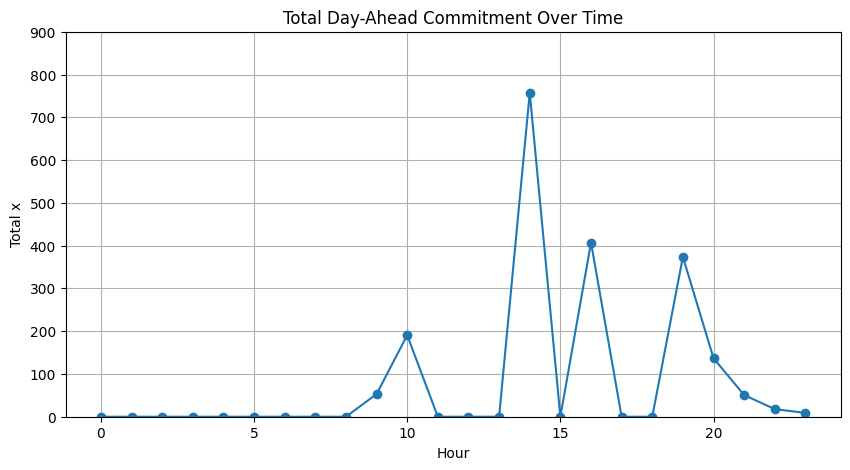

In [62]:
print("\n[ONLY MODEL] Day-Ahead Commitment (sum over DERs):")
total_only_commit = 0
for t in range(T):
    commit_t = sum(x[i, t].X for i in range(I))
    total_only_commit += commit_t
    # print(f"Time {t}: {commit_t:.2f}")
print(f"TOTAL: {total_only_commit:.2f}")

plt.figure(figsize=(10, 5))
plt.plot(range(T), x_vals.sum(axis=0), marker='o')
plt.title("Total Day-Ahead Commitment Over Time")
plt.xlabel("Hour")
plt.ylabel("Total x")
plt.ylim(0,900)
plt.grid(True)
plt.show()

In [60]:
for t in range(12,15):
    for i in range(I):
        for s in range(0,3):
            R_val  = R[i, t, s]
            x_val  = x_vals[i, t]
            yp_val = yp_vals[i, t, s]
            ym_val = ym_vals[i, t, s]
            zc_val = zc_vals[i, t, s]
            zd_val = zd_vals[i, t, s]

            lhs = R_val - x_val
            rhs = yp_val - ym_val + zc_val - zd_val

            print(f"[i={i}, t={t:02d}, s={s:02d}]  R={R_val:.2f}, x={x_val:.2f}, y⁺={yp_val:.2f}, y⁻={ym_val:.2f}, zᶜ={zc_val:.2f}, zᴰ={zd_val:.2f}")
            # print(f"                 LHS = {lhs:.2f}, RHS = {rhs:.2f}")

[i=0, t=12, s=00]  R=32.80, x=0.00, y⁺=29.00, y⁻=0.00, zᶜ=3.80, zᴰ=0.00
[i=0, t=12, s=01]  R=34.23, x=0.00, y⁺=84.23, y⁻=0.00, zᶜ=0.00, zᴰ=50.00
[i=0, t=12, s=02]  R=34.71, x=0.00, y⁺=34.71, y⁻=0.00, zᶜ=0.00, zᴰ=0.00
[i=1, t=12, s=00]  R=139.82, x=0.00, y⁺=139.82, y⁻=0.00, zᶜ=0.00, zᴰ=0.00
[i=1, t=12, s=01]  R=88.12, x=0.00, y⁺=138.12, y⁻=0.00, zᶜ=0.00, zᴰ=50.00
[i=1, t=12, s=02]  R=337.45, x=0.00, y⁺=387.45, y⁻=0.00, zᶜ=0.00, zᴰ=50.00
[i=2, t=12, s=00]  R=256.50, x=0.00, y⁺=256.50, y⁻=0.00, zᶜ=0.00, zᴰ=0.00
[i=2, t=12, s=01]  R=296.67, x=0.00, y⁺=346.67, y⁻=0.00, zᶜ=0.00, zᴰ=50.00
[i=2, t=12, s=02]  R=65.93, x=0.00, y⁺=65.93, y⁻=0.00, zᶜ=0.00, zᴰ=0.00
[i=3, t=12, s=00]  R=99.13, x=0.00, y⁺=99.13, y⁻=0.00, zᶜ=0.00, zᴰ=0.00
[i=3, t=12, s=01]  R=161.73, x=0.00, y⁺=211.73, y⁻=0.00, zᶜ=0.00, zᴰ=50.00
[i=3, t=12, s=02]  R=133.86, x=0.00, y⁺=133.86, y⁻=0.00, zᶜ=0.00, zᴰ=0.00
[i=4, t=12, s=00]  R=52.60, x=0.00, y⁺=52.60, y⁻=0.00, zᶜ=0.00, zᴰ=0.00
[i=4, t=12, s=01]  R=130.33, x=0.00, y⁺=180.33

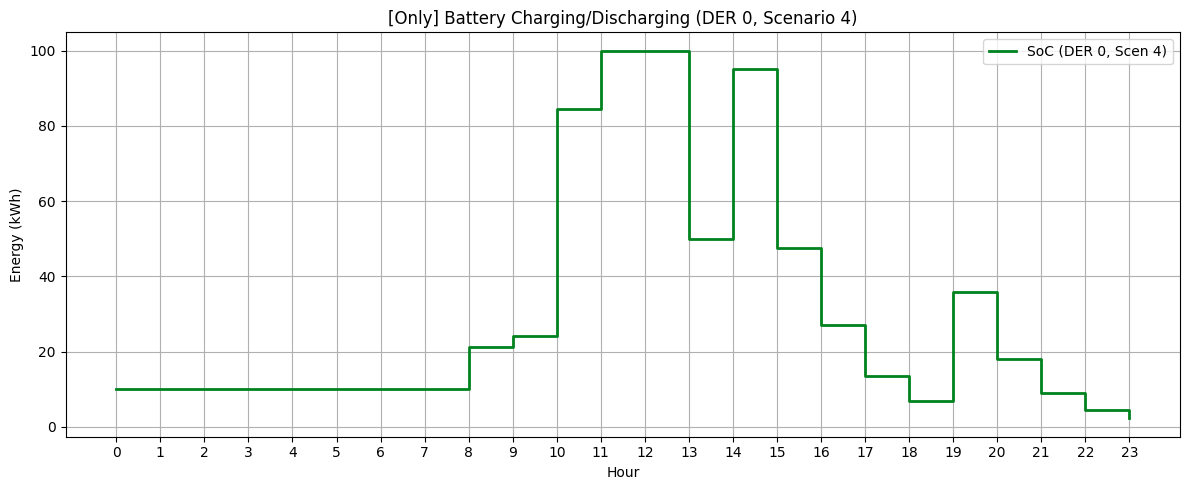

In [61]:
i=0
s=4
zc_single = zc_vals[i, :, s]  
zd_single = zd_vals[i, :, s]
z_single = z_vals[i, :, s]
hours = np.arange(len(zc_single))

plt.figure(figsize=(12, 5))
# plt.step(hours, zc_single, where='post', label=f"Charge (DER {i}, Scen {s})", color = 'green', linestyle = "--", linewidth = 1.5)
# plt.step(hours, zd_single, where='post', label=f"Discharge (DER {i}, Scen {s})", linestyle = "--", color = 'red')
plt.step(hours, z_single, where='post', label=f"SoC (DER {i}, Scen {s})", color='#00821E', linewidth=2)
plt.title(f"[Only] Battery Charging/Discharging (DER {i}, Scenario {s})")
plt.xlabel("Hour")
plt.ylabel("Energy (kWh)")
plt.xticks(hours)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()